In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Load and preprocess dataset
def load_and_preprocess_dataset(base_dir):
    images = []
    labels = []
    label_map = {'infected': 1, 'notinfected': 0}  # Define label mapping

    for label in label_map.keys():
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    img_path = os.path.join(class_dir, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure RGB format
                        img = cv2.resize(img, (224, 224))  # Resize to 224x224
                        images.append(img)
                        labels.append(label_map[label])

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, label_map

In [2]:
def preprocess_images(images):
    preprocessed_images = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    for img in images:
        if len(img.shape) == 3 and img.shape[2] == 3:  # if it's a color image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       
        img_clahe = clahe.apply(img)
        img_resized = cv2.resize(img_clahe, (224, 224))
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)
        img_preprocessed = preprocess_input(img_resized)
        preprocessed_images.append(img_preprocessed)
   
    return np.array(preprocessed_images)

In [3]:
# Load the dataset
base_dir = 'data'
images, labels, label_map = load_and_preprocess_dataset(base_dir)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Preprocess images
X_train = preprocess_images(X_train)
X_val = preprocess_images(X_val)
X_test = preprocess_images(X_test)

# Create ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the training data
datagen.fit(X_train)

In [4]:
# Define the model
from keras.layers import BatchNormalization
from keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
   
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
   
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
   
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
   
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=20,
                    validation_data=(X_val, y_val))


Epoch 1/20
47/47 [==============================] - 94s 2s/step - loss: 0.2905 - accuracy: 0.8822 - val_loss: 0.4024 - val_accuracy: 0.8802
Epoch 2/20
47/47 [==============================] - 86s 2s/step - loss: 0.0832 - accuracy: 0.9794 - val_loss: 0.3857 - val_accuracy: 0.8802
Epoch 3/20
47/47 [==============================] - 105s 2s/step - loss: 0.0351 - accuracy: 0.9907 - val_loss: 0.1976 - val_accuracy: 0.9115
Epoch 4/20
47/47 [==============================] - 90s 2s/step - loss: 0.0219 - accuracy: 0.9967 - val_loss: 0.0850 - val_accuracy: 1.0000
Epoch 5/20
47/47 [==============================] - 92s 2s/step - loss: 0.0211 - accuracy: 0.9947 - val_loss: 0.0358 - val_accuracy: 1.0000
Epoch 6/20
47/47 [==============================] - 90s 2s/step - loss: 0.0113 - accuracy: 0.9980 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 7/20
47/47 [==============================] - 89s 2s/step - loss: 0.0096 - accuracy: 0.9980 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 8/20
47/47 [=

6/6 [==============================] - 2s 377ms/step - loss: 4.9953e-05 - accuracy: 1.0000
Test accuracy: 1.0


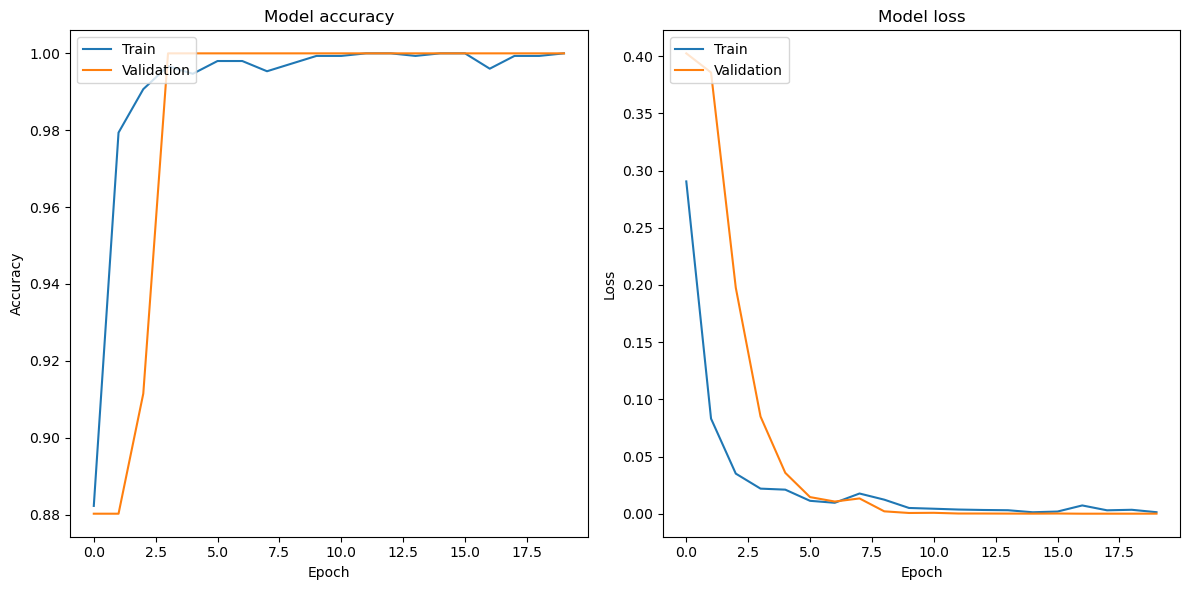

In [5]:
# Evaluate the model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

48/48 [==============================] - 18s 385ms/step
Train accuracy: 1.0
6/6 [==============================] - 2s 373ms/step


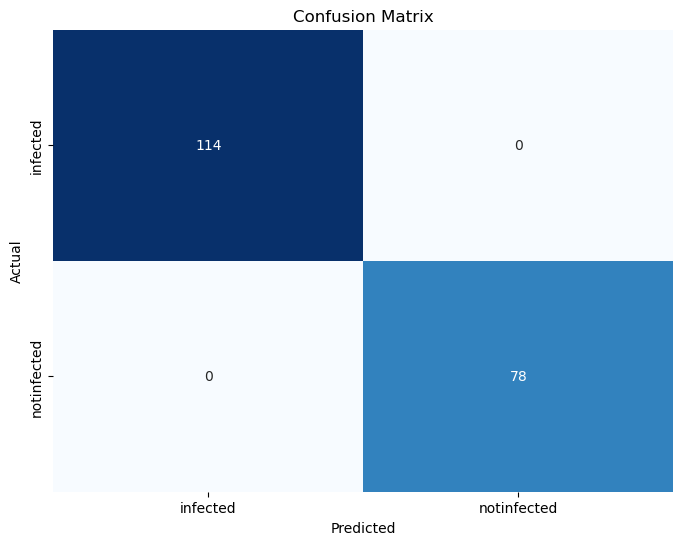

In [10]:
# Predict on training set
y_train_pred_prob = model.predict(X_train)

# Convert probabilities to binary class labels (using 0.5 as threshold)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

# Calculate training accuracy
train_acc = accuracy_score(y_train, y_train_pred)
print(f'Train accuracy: {train_acc}')

# Predict on test set
y_pred_prob = model.predict(X_test)

# Convert test probabilities to binary class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['notinfected', 'infected']))

              precision    recall  f1-score   support

 notinfected       1.00      1.00      1.00       114
    infected       1.00      1.00      1.00        78

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



6/6 [==============================] - 2s 377ms/step


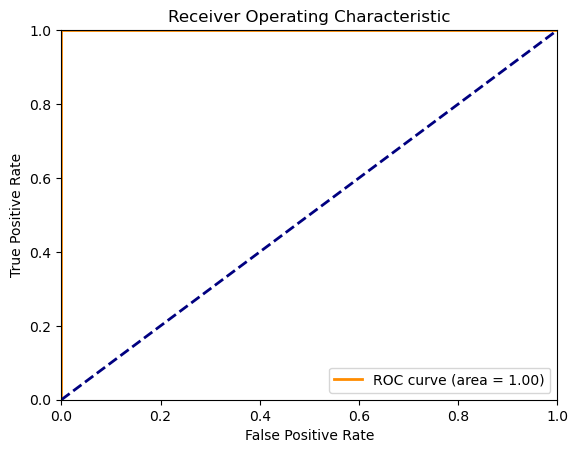

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


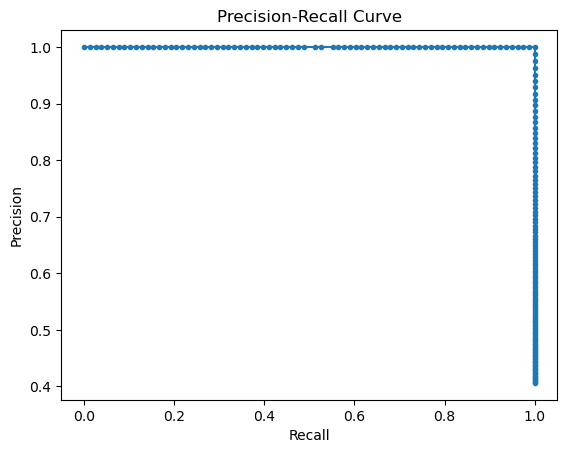

In [16]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [17]:
from sklearn.metrics import log_loss

loss = log_loss(y_test, y_prob)
print(f'Log Loss: {loss}')

Log Loss: 4.9962550851892875e-05


In [18]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_pred)
print(f'Matthews Correlation Coefficient: {mcc}')

Matthews Correlation Coefficient: 1.0


In [19]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_test, y_pred)
print(f'Cohen\'s Kappa: {kappa}')

Cohen's Kappa: 1.0


In [20]:
from sklearn.metrics import balanced_accuracy_score

bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {bal_acc}')


Balanced Accuracy: 1.0


In [21]:
from sklearn.metrics import recall_score

specificity = recall_score(y_test, y_pred, pos_label=0)
print(f'Specificity: {specificity}')

Specificity: 1.0


In [22]:
from sklearn.metrics import fbeta_score

f2_score = fbeta_score(y_test, y_pred, beta=2)
print(f'F2 Score: {f2_score}')

F2 Score: 1.0


In [32]:
# Predict probabilities on the validation/test set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to binary class labels using a threshold of 0.5
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')


6/6 [==============================] - 2s 376ms/step
Validation Accuracy: 1.0000


In [33]:
# Classification report for training set
print("Training Set Classification Report")
print(classification_report(y_train, y_train_pred, target_names=['Not Infected', 'Infected']))

# Classification report for validation/test set
print("Validation Set Classification Report")
print(classification_report(y_val, y_val_pred, target_names=['Not Infected', 'Infected']))


Training Set Classification Report
              precision    recall  f1-score   support

Not Infected       1.00      1.00      1.00       910
    Infected       1.00      1.00      1.00       625

    accuracy                           1.00      1535
   macro avg       1.00      1.00      1.00      1535
weighted avg       1.00      1.00      1.00      1535

Validation Set Classification Report
              precision    recall  f1-score   support

Not Infected       1.00      1.00      1.00       114
    Infected       1.00      1.00      1.00        78

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



In [34]:
# Predict probabilities for log loss calculation
y_train_proba = model.predict(X_train)
y_val_proba = model.predict(X_val)

# Log Loss for training set
train_log_loss = log_loss(y_train, y_train_proba)
print(f'Training Log Loss: {train_log_loss:.4f}')

# Log Loss for validation/test set
val_log_loss = log_loss(y_val, y_val_proba)
print(f'Validation Log Loss: {val_log_loss:.4f}')

6/6 [==============================] - 3s 479ms/step
Training Log Loss: 0.0001
Validation Log Loss: 0.0001
